
<center><h1> Assignment I </h1><br> <h2>Linear Regression</h2></center>
   

# Generating Synthetic Data

This assignment shows how we can extend ordinary least squares regression, which uses the hypothesis class of linear regression functions, to non-linear regression functions modeled using polynomial basis functions and radial basis functions. The function we want to fit is $y_\mathsf{true} \, = \, f_\mathsf{true}(x) \, = \, 6 (\sin(x + 2) + \sin(2x + 4)) $. This is a **univariate function** as it has only one input variable. First, we generate synthetic input (data) $x_i$ by sampling $n=750$ points from a uniform distribution on the interval $[-7.5, \, 7.5]$.

In [1]:
# The true function
def f_true(x):
  y = 6.0 * (np.sin(x + 2) + np.sin(2*x + 4))
  return y
  

We can generate a synthetic data set, with Gaussian noise.

In [2]:
import numpy as np                       # For all our math needs
n = 750                                  # Number of data points
X = np.random.uniform(-7.5, 7.5, n)      # Training examples, in one dimension
e = np.random.normal(0.0, 5.0, n)        # Random Gaussian noise
y = f_true(X) + e                        # True labels with noise

Now, we plot the raw data as well as the true function (without noise).

Matplotlib is building the font cache; this may take a moment.


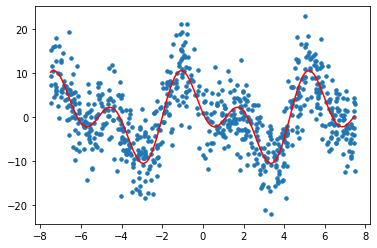

In [3]:
import matplotlib.pyplot as plt          # For all our plotting needs
plt.figure()

# Plot the data
plt.scatter(X, y, 12, marker='o')           

# Plot the true function, which is really "unknown"
x_true = np.arange(-7.5, 7.5, 0.05)
y_true = f_true(x_true)
plt.plot(x_true, y_true, marker='None', color='r')

Recall that we want to build a model to **generalize well on future data**, and in order to generalize well on future data, we need to pick a model that trade-off well between fit and complexity (that is, bias and variance). We randomly split the overall data set ($\mathcal{D}$) into three subsets:
* **Training set**: $\mathcal{D}_\mathsf{trn}$ consists of the actual training examples that will be used to **train the model**;
* **Validation set**: $\mathcal{D}_\mathsf{val}$ consists of validation examples that will be used to **tune model hyperparameters** (such as $\lambda > 0$ in ridge regression) in order to find the best trade-off between fit and complexity (that is, the value of $\lambda$ that produces the best model);
* **Test set**: $\mathcal{D}_\mathsf{tst}$ consists of test examples to **estimate how the model will perform on future data**.
![](https://cdn-images-1.medium.com/max/800/1*Nv2NNALuokZEcV6hYEHdGA.png)

For this example, let us randomly partition the data into three non-intersecting sets: $\mathcal{D}_\mathsf{trn} = 60\%$ of $\mathcal{D}$, $\mathcal{D}_\mathsf{val} = 10\%$ of $\mathcal{D}$ and $\mathcal{D}_\mathsf{tst} = 30\%$ of $\mathcal{D}$. 

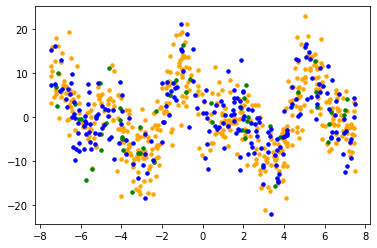

In [4]:
# scikit-learn has many tools and utilities for model selection
from sklearn.model_selection import train_test_split
tst_frac = 0.3  # Fraction of examples to sample for the test set
val_frac = 0.1  # Fraction of examples to sample for the validation set

# First, we use train_test_split to partition (X, y) into training and test sets
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=tst_frac, random_state=42)

# Next, we use train_test_split to further partition (X_trn, y_trn) into training and validation sets
X_trn, X_val, y_trn, y_val = train_test_split(X_trn, y_trn, test_size=val_frac, random_state=42)

# Plot the three subsets
plt.figure()
plt.scatter(X_trn, y_trn, 12, marker='o', color='orange')
plt.scatter(X_val, y_val, 12, marker='o', color='green')
plt.scatter(X_tst, y_tst, 12, marker='o', color='blue')

# 1. <font color='#556b2f'> **Regression with Polynomial Basis Functions**</font>, 30 points. 

This problem extends **ordinary least squares regression**, which uses the hypothesis class of _linear regression functions_, to _non-linear regression functions_ modeled using **polynomial basis functions**. In order to learn nonlinear models using linear regression, we have to explicitly **transform the data** into a higher-dimensional space. The nonlinear hypothesis class we will consider is the set of $d$-degree polynomials of the form $f(x) \, = \, w_0 + w_1 x + w_2 x^2 + ... + w_d x^d$ or **a linear combination of polynomial basis function**:

<div align="center">
$
        f(x) = [w_0, \, w_1,\, w_2 \, ..., w_d]^T \left[ \begin{array}{c} 1 \\ x \\ x^2 \\ \vdots \\ x^d\end{array} \right]
$.
</div>

The monomials $\{ 1, \,  x, \, x^2, \, ..., \,  x^d\}$ are called **basis functions**, and each basis function $x^k$ has a corresponding weight $w_k$ associated with it, for all $k \, = \, 1, ..., d$. We transform each univariate data point $x_i$ into into a multivariate ($d$-dimensional) data point via  $\phi(x_i) \rightarrow [1, \,  x_i, \, x_i^2, \, \, ..., \,  x^d_i]$. When this transformation is applied to every data point, it produces the **Vandermonde matrix**:

<div align="center">
$
        \Phi \, = \,
        \left[
        \begin{array}{ccccc}
            1 &  x_1 & x_1^2 & ... &  x_1^d\\
            1 &  x_2 & x_2^2 & ... &  x_2^d\\
            \vdots &   \vdots & \vdots & \ddots &  \vdots\\
            1 &  x_n & x_n^2 & \cdots &  x_n^d\\
        \end{array}
        \right]
$.
</div>

--- 
### **a**. (10 points) 
Complete the Python function below that takes univariate data as input and computes a Vandermonde matrix of dimension $d$. This transforms one-dimensional data into $d$-dimensional data in terms of the polynomial basis and allows us to model regression using a $d$-degree polynomial.

In [9]:
# X float(n, ): univariate data
# d int: degree of polynomial  
def polynomial_transform(X, d):
    Phi = np.vander(X,d)
    return Phi
# Phi = polynomial_transform(X, 3)
# print(Phi)

---
### **b**. (10 points) 
Complete the Python function below that takes a Vandermonde matrix $\Phi$ and the labels $\mathbf{y}$ as input and learns weights via **ordinary least squares regression**. Specifically, given a Vandermonde matrix $\Phi$, implement the computation of $\mathbf{w} \, = \, (\Phi^T \Phi)^{-1}\Phi^T\mathbf{y}$. _Remember that in Python, @ performs matrix multiplication, while * performs element-wise multiplication. Alternately, [numpy.dot](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.dot.html) also performs matrix multiplication._ 

In [10]:
# Phi float(n, d): transformed data
# y   float(n,  ): labels
from numpy.linalg import inv
def train_model(Phi, y):
    w = (inv(Phi.T@Phi))@Phi.T@y
    return w
# w = train_model(Phi, y)
# print(w)

---
### **c**. (5 points) 
Complete the Python function below that takes a Vandermonde matrix $\Phi$, corresponding labels $\mathbf{y}$, and a linear regression model $\mathbf{w}$ as input and evaluates the model using **mean squared error**. That is, $\epsilon_\mathsf{MSE} \, = \, \frac{1}{n} \sum_{i=1}^n \, (y_i \, - \, \mathbf{w}^T \Phi_i)^2$.

In [11]:
# Phi float(n, d): transformed data
# y   float(n,  ): labels
# w   float(d,  ): linear regression model
def evaluate_model(Phi, y, w):
    tot = 0
    for i in range(Phi.shape[0]):
        x = (y[i] - (w.T@Phi[i]))**2
        tot = tot + x
    mse = (1/Phi.shape[0])*tot
    return mse
# mse = evaluate_model(Phi, y, w)
# print(mse)

---
### **d**. (5 points, **Discussion**) 
We can explore the **effect of complexity** by varying $d = 3, 6, 9,\, \cdots, 24$ to steadily increase the non-linearity of the models. For each model, we train using the transformed training data ($\Phi$, whose dimension increases) and evaluate its performance on the transformed validation data and estimate what our future accuracy will be using the test data.

From plot of $d$ vs. validation error below, which choice of $d$ do you expect will generalize best? 

(2.0, 25.0, 15.0, 60.0)

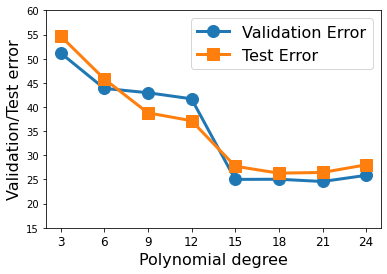

In [12]:
w = {}               # Dictionary to store all the trained models
validationErr = {}   # Validation error of the models
testErr = {}         # Test error of all the models

for d in range(3, 25, 3):  # Iterate over polynomial degree
    Phi_trn = polynomial_transform(X_trn, d)                 # Transform training data into d dimensions
    w[d] = train_model(Phi_trn, y_trn)                       # Learn model on training data
    
    Phi_val = polynomial_transform(X_val, d)                 # Transform validation data into d dimensions
    validationErr[d] = evaluate_model(Phi_val, y_val, w[d])  # Evaluate model on validation data
    
    Phi_tst = polynomial_transform(X_tst, d)           # Transform test data into d dimensions
    testErr[d] = evaluate_model(Phi_tst, y_tst, w[d])  # Evaluate model on test data

# Plot all the models
plt.figure()
plt.plot(validationErr.keys(), validationErr.values(), marker='o', linewidth=3, markersize=12)
plt.plot(testErr.keys(), testErr.values(), marker='s', linewidth=3, markersize=12)
plt.xlabel('Polynomial degree', fontsize=16)
plt.ylabel('Validation/Test error', fontsize=16)
plt.xticks(list(validationErr.keys()), fontsize=12)
plt.legend(['Validation Error', 'Test Error'], fontsize=16)
plt.axis([2, 25, 15, 60])

---
Finally, let's visualize each learned model.

(-8.0, 8.0, -15.0, 15.0)

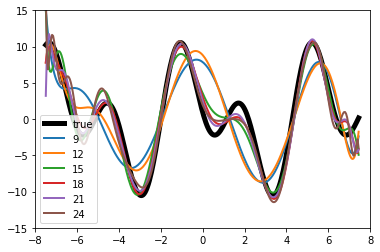

In [13]:
plt.figure()
plt.plot(x_true, y_true, marker='None', linewidth=5, color='k')

for d in range(9, 25, 3):
  X_d = polynomial_transform(x_true, d)
  y_d = X_d @ w[d]
  plt.plot(x_true, y_d, marker='None', linewidth=2)

plt.legend(['true'] + list(range(9, 25, 3)))
plt.axis([-8, 8, -15, 15])

---
# 2. <font color='#556b2f'> **Regression with Radial Basis Functions**</font>, 70 points


In the previous case, we considered a nonlinear extension to linear regression using a linear combination of polynomial basis functions, where each basis function was introduced as a feature $\phi(x) = x^k$. Now, we consider Gaussian radial basis functions of the form:
<div align="center">
$\phi(\mathbf{x}) = e^{-\gamma \,  (x - \mu)^2}$, 
</div>
whose shape is defined by its center $\mu$ and its width $\gamma > 0$. In the case of polynomial basis regression, the user's choice of the dimension $d$ determined the transformation and the model. For radial basis regression, we have to contend with deciding how many radial basis functions we should have, and what their center and width parameters should be. For simplicity, let's assume that $\gamma = 0.1$ is fixed. Instead of trying to identify the number of radial basis functions or their centers, we can treat **each data point as the center of a radial basis function**, which means that the model will be:

<div align="center">
$
f(x) = [w_1, \, w_2,\, w_3 \, ..., w_n]^T \left[ \begin{array}{c} e^{-\gamma \,  (x - x_1)^2} \\ e^{-\gamma \,  (x - x_2)^2} \\ e^{-\gamma \,  (x - x_2)^2} \\ ... \\ e^{-\gamma \,  (x - x_n)^2} \end{array} \right]
$.
</div>

This transformation uses radial basis functions centered around data points $e^{-\gamma \,  (x - x_i)^2}$ and each basis function has a corresponding weight $w_i$ associated with it, for all $i \, = \, 1, ..., n$. We transform each univariate data point $x_j$ into into a multivariate ($n$-dimensional) data point via  $\phi(x_j) \rightarrow [..., e^{-\gamma \,  (x_j - x_i)^2}, \, ...]$. When this transformation is applied to every data point, it produces the **radial-basis kernel**:

<div align="center">
$
        \Phi \, = \,
        \left[
        \begin{array}{ccccc}
            1 &  e^{-\gamma \,  (x_1 - x_2)^2} & e^{-\gamma \,  (x_1 - x_3)^2} & ... &  e^{-\gamma \,  (x_1 - x_n)^2}\\
            e^{-\gamma \,  (x_2 - x_1)^2} &  1 & e^{-\gamma \,  (x_2 - x_3)^2} & ... & e^{-\gamma \,  (x_2 - x_n)^2}\\
            \vdots &   \vdots & \vdots & \ddots &  \vdots\\
            e^{-\gamma \,  (x_n - x_1)^2} & e^{-\gamma \,  (x_n - x_2)^2} & e^{-\gamma \,  (x_n - x_3)^2} & \cdots &  1\\
        \end{array}
        \right]
$.
</div>

--- 
### **a**. (15 points) 
Complete the Python function below that takes univariate data as input and computes a radial-basis kernel. This transforms one-dimensional data into $n$-dimensional data in terms of Gaussian radial-basis functions centered at each data point and allows us to model nonlinear (kernel) regression.

In [ ]:
# X float(n, ): univariate data
# B float(n, ): basis functions
# gamma float : standard deviation / scaling of radial basis kernel
def radial_basis_transform(X, B, gamma=0.1):
  #
  #
  # *** Insert your code here ***
  #
  #

---
### **b**. (15 points) 
Complete the Python function below that takes a radial-basis kernel matrix $\Phi$, the labels $\mathbf{y}$, and a regularization parameter $\lambda > 0$ as input and learns weights via **ridge regression**. Specifically, given a radial-basis kernel matrix $\Phi$, implement the computation of $\mathbf{w} \, = \, \left( \Phi^T \Phi + \lambda I_n \right)^{-1} \, \Phi^T\mathbf{y}$.

In [ ]:
# Phi float(n, d): transformed data
# y   float(n,  ): labels
# lam float      : regularization parameter
def train_ridge_model(Phi, y, lam):
  #
  #
  # *** Insert your code here ***
  #
  #

---
### **c**. (30 points)  
As before, we can explore the tradeoff between **fit and complexity** by varying $\lambda \in [10^{-3}, 10^{-2}\, \cdots, 1, \, \cdots\, 10^3]$. For each model, train using the transformed training data ($\Phi$) and evaluate its performance on the transformed validation and test data. Plot two curves: (i) $\lambda$ vs. validation error and (ii) $\lambda$ vs. test error, as above. 

What are some ideal values of $\lambda$? 

In [ ]:
#
# *** Insert your code here ***
#

### **d**. (10 points, **Discussion**) 
Plot the learned models as well as the true model similar to the polynomial basis case above. How does the linearity of the model change with $\lambda$?

In [ ]:
#
# *** Insert your code here ***
#

#### You have to submit a single .py file that contains all the code. 